In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import keras
import json

Using TensorFlow backend.


### Load the category file

The category file contains all category classes we designed. Right now they are 
 "sports",
 "shows",
 "free",
 "art",
 "nightlife",
 "family",
 ,"professional", and "Food&Drink"

In [2]:
with open("categories.json","r") as fp:
    categories = json.load(fp)
print categories

[u'Sports', u'Shows', u'Free', u'Art', u'Nightlife', u'Family', u'Professional', u'Food&Drink']


### Load events dataset

In [6]:
with open("LabeledEvent.json","r") as fp:
    train = json.load(fp)
x = []
y = []
for event in train:
    text = ""
    if 'description' in event and event['description']:
        text += event['description']
    if 'title' in event and event['title']:
        text += event['title']
    if not text or not event['primaryCategory']:
        continue
    x.append(text)
    y.append(event['primaryCategory'])
labelsFreq = Counter(y)

### Encode event label

#### Train with events with single label

In [7]:
encoder = LabelEncoder()
encoder.fit(categories)
encoded_y = encoder.transform(y)
print encoded_y
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(encoded_y)

[1 6 0 2 0 2 6 6 5 6 2 6 4 5 2 6 5 4 6 1 1 6 6 7 3 6 5 5 6 6 1 7 6 5 1 4 6
 2 5 6 1 5 2 1 6 6 6 4 7 4 4 0 1 2 5 1 7 6 2 6 4 2 7 6 0 6 6 2 4 6 6 7 2 2
 6 2 5 7 6 3 2 1 1 6 1 6 6 6 6 4 0 5 6 4 6 5 6 1 0 2 1 6 0 4 6 6 5 6 5 4 1
 5 6 5 5 7 4 7 3 6 2 6 5 0 5 7 2 2 7 1 1 6 7 2 6 6 4 4 6 7 7 5 6 4 6 7 2 4
 6 6 2 6 4 7 1 7 6 2 6 0 5 6 6 5 6 5 5 6 6 1 5 6 5 1 5 1 6 5 4 5 0 1 5 6 2
 6 5 1 5 6 7 7 5 6 1 2 6 1 4 6 5 1 5 6 6 4 5 6 6 2 5 1 6 1 5 6 2 1 5 4 2 6
 6 6 6 5 1 4 5 2 6 3 0 6 3 3 6 7 6 6 0 5 4 1 5 5 1 5 7 1 4 2 0 6 1 7 0 6 2
 6 6 0 2 6 0 5 6 2 5 2 4 6 2 6 0 1 2 6 4 6 7 1 6 0 7 6 1 1 7 6 6 1 6 2 1 1
 7 5 4 5]


#### Insights of Dataset

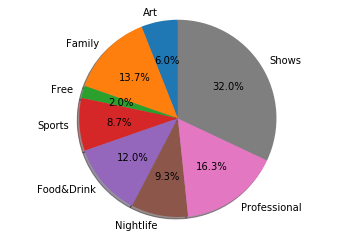

In [36]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
for category in labelsFreq:
    labels.append(category)
    sizes.append(labelsFreq[category])

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

#### Train with event with multiple labels

In [12]:
# with open("train_fake_multiLabel.json","r") as fp:
#     train = json.load(fp)
# x = [event['text'] for event in train]
# y = [event['category'] for event in train]
# print y
# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(y)
# print y

#### Tokenize event text

In [8]:
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=180, padding="post")

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9000)

### Build the model

In [10]:
filter_length = 300
max_words = 5000
num_classes = len(y[0])
maxlen = 180

In [11]:
model = Sequential()
model.add(Embedding(max_words, 20, input_length=maxlen))
model.add(Dropout(0.1))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
model.summary()

callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=4),
    ModelCheckpoint(filepath='model_category.h5', save_best_only=True)
]

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 180, 20)           100000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 180, 20)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 178, 300)          18300     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 2408      
_________________________________________________________________
activation_1 (Activat

In [12]:
model_json = model.to_json()
with open("model_category.json", "w") as json_file:
    json_file.write(model_json)
metrics = model.evaluate(x_test, y_test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

60/60 [==============================] - 0s 300us/step
loss: 0.335984800259
categorical_accuracy: 0.36666667064
